In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import os
import cv2

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

### Đọc dữ liệu

In [3]:
# đọc tên các lớp :  có 9 loại
# DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [28]:
data = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append([img, folder])

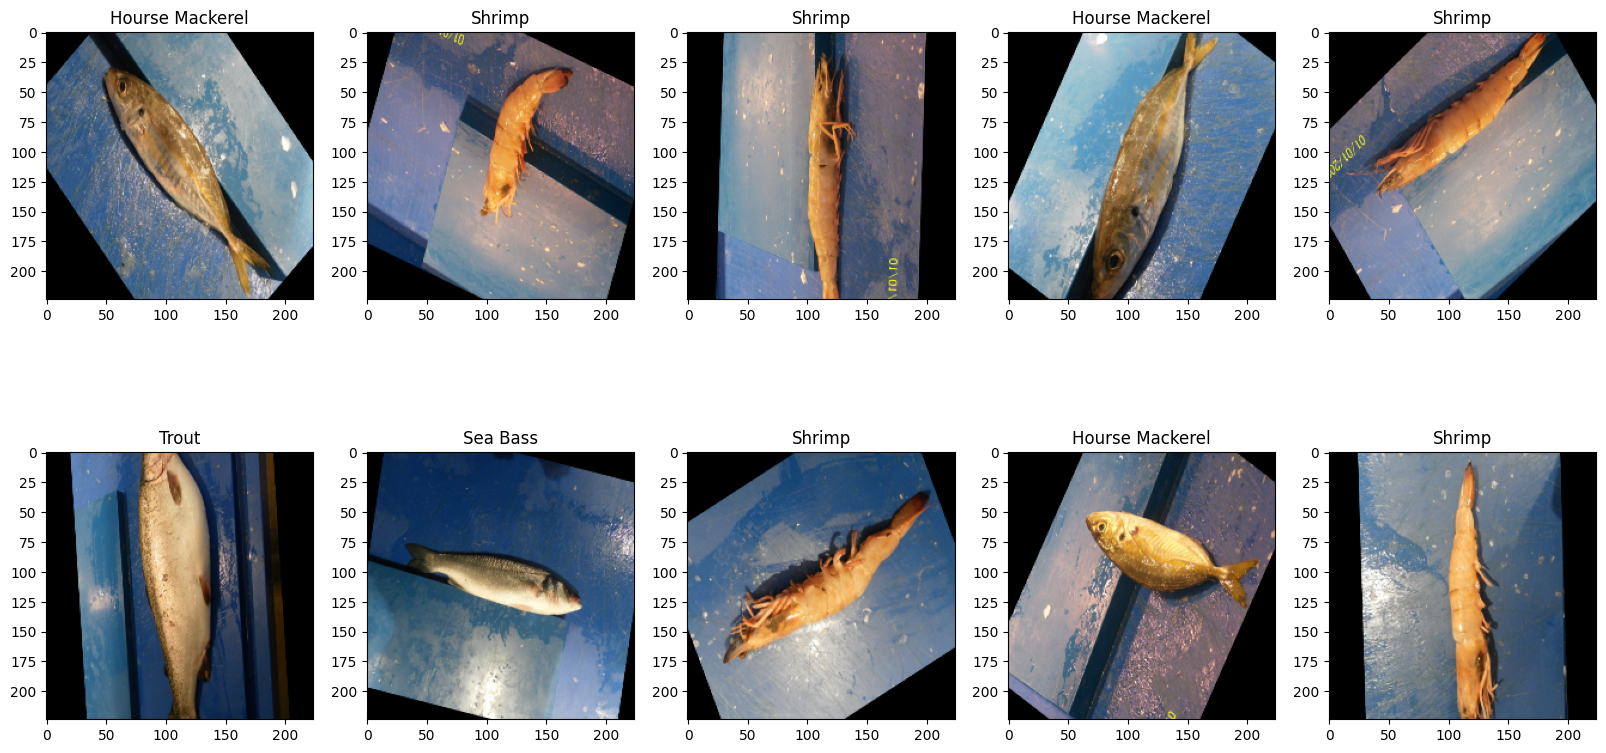

In [29]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [30]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [31]:
images, test_images, labels, test_labels = train_test_split(images, labels, test_size=0.05, random_state=42, stratify=labels)

##### TRAIN

In [32]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [33]:
# giảm chiều dữ liệu image
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(8550, 224, 224, 3)

In [35]:
# duỗi ảnh thành vector
images = images.reshape(images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 224x224x3 = 150528 pixel

In [37]:
images.shape

(8550, 150528)

In [38]:
labels.shape

(8550,)

### Chia dữ liệu Train và Validation

In [40]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((6840, 150528), (1710, 150528), (6840,), (1710,))

In [41]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 760, 1: 760, 2: 760, 3: 760, 4: 760, 5: 760, 6: 760, 7: 760, 8: 760}

### Xây dựng model

In [42]:
logisticRegr = LogisticRegression(tol=0.1, solver='lbfgs', multi_class='multinomial', max_iter=100, C=0.1)
logisticRegr.fit(train_images, train_labels)

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, multi_class='multinomial', tol=0.1)

### Đánh giá mô hình

In [43]:
result = logisticRegr.predict(val_images)

Text(0.5, 23.52222222222222, 'Predicted label')

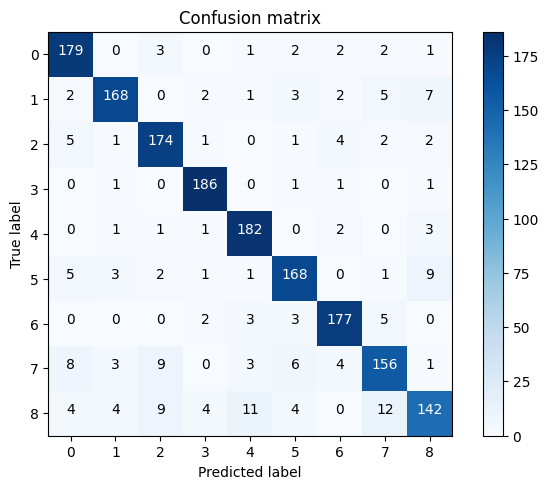

In [44]:
classes = 9
cm = confusion_matrix(val_labels, result)

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [45]:
# tính accuracy, recall, precision
print("Accuracy: ", accuracy_score(val_labels, result))
print("Recall: ", recall_score(val_labels, result, average='macro'))
print("Precision: ", precision_score(val_labels, result, average='macro'))

Accuracy:  0.895906432748538
Recall:  0.895906432748538
Precision:  0.8952514814842131


##### TEST

In [47]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [48]:
# giảm chiều dữ liệu image
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(450, 224, 224, 3)

In [49]:
test_images = test_images.reshape(test_images.shape[0], -1) 

In [50]:
# đánh giá trên tập test
result = logisticRegr.predict(test_images)

Text(0.5, 23.52222222222222, 'Predicted label')

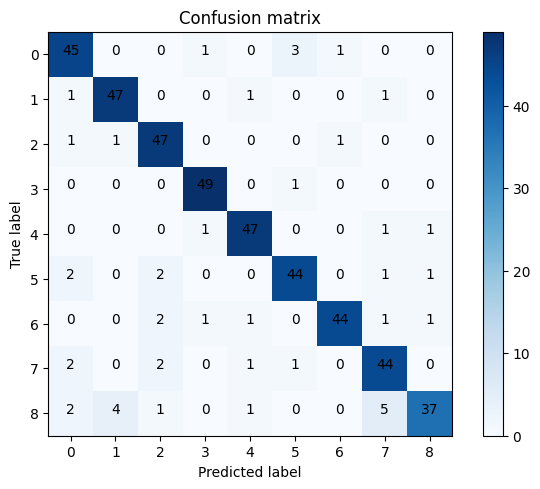

In [51]:
classes = 9
cm = confusion_matrix(test_labels, result)

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [52]:
# tính accuracy, recall, precision
print("Accuracy: ", accuracy_score(test_labels, result))
print("Recall: ", recall_score(test_labels, result, average='macro'))
print("Precision: ", precision_score(test_labels, result, average='macro'))

Accuracy:  0.8977777777777778
Recall:  0.8977777777777778
Precision:  0.8996465610886634


#### Test Model

In [53]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data_test.append([img, folder])

In [54]:
# shuffle data_test
import random
random.shuffle(data_test)

In [55]:
# tạo image và label từ data
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [56]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [57]:
# giảm chiều dữ liệu image
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 224, 224, 3)

In [58]:
# duỗi ảnh thành vector
test_images = test_images.reshape(430, -1) # 430 ảnh, mỗi ảnh có 224x224x3 = 150528 pixel

In [59]:
result = logisticRegr.predict(test_images)

Text(0.5, 23.52222222222222, 'Predicted label')

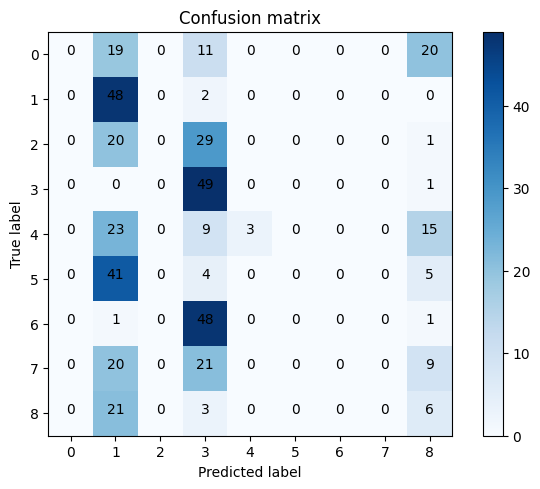

In [60]:
classes = 9
cm = confusion_matrix(test_labels, result)

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [61]:
# tính accuracy, recall, precision
print("Accuracy: ", accuracy_score(test_labels, result))
print("Recall: ", recall_score(test_labels, result, average='macro'))
print("Precision: ", precision_score(test_labels, result, average='macro'))

Accuracy:  0.24651162790697675
Recall:  0.24444444444444446
Precision:  0.1811735588870661


c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
